In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# Construct a tf.data.Dataset
train_ds_unbatched, train_info = tfds.load('lfw', split='train[:80%]', with_info=True)
test_ds_unbatched, test_info = tfds.load('lfw', split='train[80%:]', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteO0UADU/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
train_ds_unbatched

<PrefetchDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>

In [5]:
train_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
INP_SIZE = 224

train_x = []
train_y = []
for k, ds in enumerate(train_ds_unbatched):
    img = ds["image"].numpy().astype(np.float32)/255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    train_x.append(img)
    train_y.append(ds["label"].numpy())
    if k >= 2999:
      break

In [7]:
train_x = np.array(train_x)
train_x.shape

(3000, 224, 224, 3)

In [8]:
train_y = np.array(train_y)
train_y[0]

b'Tom_Amstutz'

In [9]:
train_y.shape

(3000,)

In [10]:
test_x = []
test_y = []
for k, ds in enumerate(test_ds_unbatched):
    img = ds["image"].numpy().astype(np.float32)/255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    test_x.append(img)
    test_y.append(ds["label"].numpy())
    if k >= 999:
      break
test_x = np.array(test_x)
test_y = np.array(test_y)
test_x.shape

(1000, 224, 224, 3)

In [11]:
del train_ds_unbatched
del test_ds_unbatched

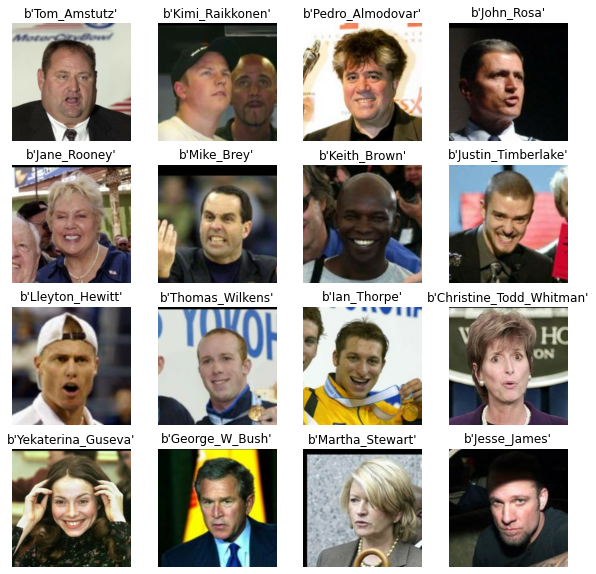

In [12]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(train_x[i])
    plt.title(train_y[i])
    plt.axis("off")

### Создание позитивных и негативных пар

In [13]:
def create_pairs(x, y):
    '''
    Positive and negative pair creation.
    '''
    pairs = []
    labels = []

    unique = np.unique(y)
    digit_indices = [np.where(y == i)[0] for i in unique]
    negatives = list(filter(lambda x: len(x) == 1, digit_indices))
    positives = list(filter(lambda x: len(x) >= 2, digit_indices))
    for d in positives:
        for i in range(len(d) // 2):
            z1, z2 = d[i], d[i + 1]
            pairs += [[x[z1], x[z2]]]

            z1, z2 = random.choice(negatives)[0], random.choice(negatives)[0]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [14]:
tr_pairs, tr_y = create_pairs(train_x, train_y)
te_pairs, te_y = create_pairs(train_x, train_y)

In [15]:
np.array(tr_pairs).shape

(1402, 2, 224, 224, 3)

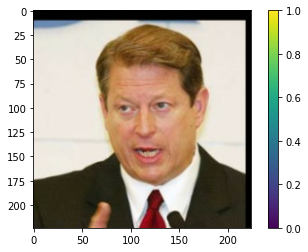

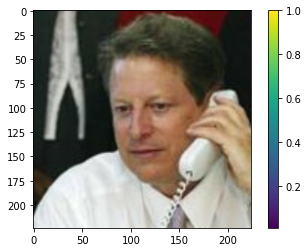

1


In [16]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

this_pair = 10
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

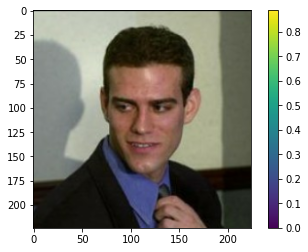

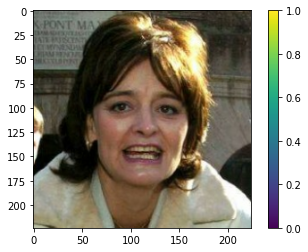

0


In [17]:
this_pair = 11
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

### Создание модели CNN

In [28]:
EMB_SIZE = 256
INP_SIZE = 224

base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели

b_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [49]:
@tf.function
def contrastive_loss(y_true, D, margin = 1):
    Y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(Y_true * tf.square(D) + (1-Y_true) * tf.maximum((margin-D),0))

@tf.function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

@tf.function
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

In [36]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	#plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")

In [30]:
input_shape = tr_pairs.shape[2:]
input_shape

(224, 224, 3)

In [50]:
input_a = tf.keras.layers.Input(input_shape, name="Left_input")
processed_a = b_model(input_a)
input_b = tf.keras.layers.Input(input_shape, name="Right_input")
processed_b = b_model(input_b)

#distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
distance = tf.keras.layers.Lambda(euclidean_distance)([processed_a, processed_b])

In [51]:
# На входе у нас две картинки , на выходе модели дистанция выходных векторов.
model = tf.keras.models.Model([input_a, input_b], outputs=distance)
# Оптимизатор
optim = tf.keras.optimizers.Adam(learning_rate=0.002)
# Собираем модель
model.compile(loss=contrastive_loss, optimizer=optim, metrics=[accuracy_sim])

In [52]:
# validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=32, epochs=5)

Epoch 1/5
44/44 [==============================] - 25s 422ms/step - loss: 0.4355 - accuracy_sim: 0.3048
Epoch 2/5
44/44 [==============================] - 18s 412ms/step - loss: 0.2029 - accuracy_sim: 0.2049
Epoch 3/5
44/44 [==============================] - 18s 411ms/step - loss: 0.1530 - accuracy_sim: 0.1556
Epoch 4/5
44/44 [==============================] - 18s 406ms/step - loss: 0.1216 - accuracy_sim: 0.1056
Epoch 5/5
44/44 [==============================] - 18s 407ms/step - loss: 0.1091 - accuracy_sim: 0.1059


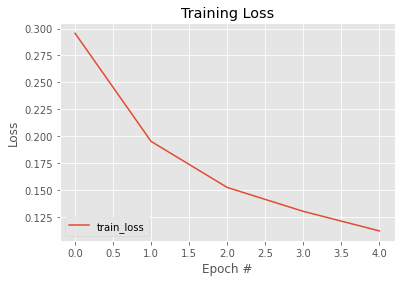

In [53]:
plot_training(history)

In [54]:
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

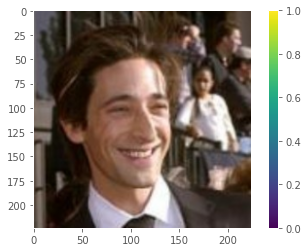

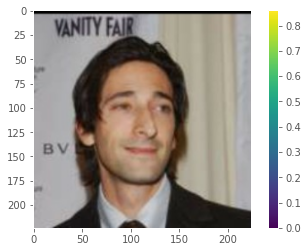

1
[0.81807035]
1


In [56]:
this_pair = 2
show_image(te_pairs[this_pair][0])
show_image(te_pairs[this_pair][1])
print(te_y[this_pair])
print(y_pred[this_pair])
print(1 if y_pred[this_pair]<2 else 0)

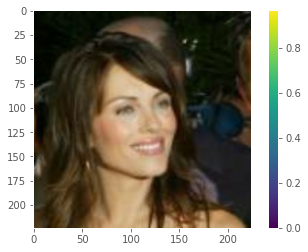

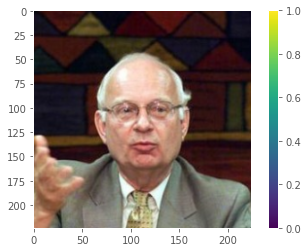

0
[3.552]
0


In [57]:
this_pair = 11
show_image(te_pairs[this_pair][0])
show_image(te_pairs[this_pair][1])
print(te_y[this_pair])
print(y_pred[this_pair])
print(1 if y_pred[this_pair]<2 else 0)

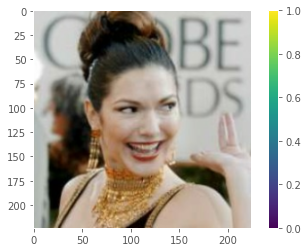

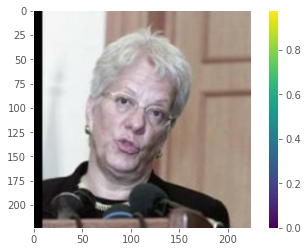

0
[2.5848224]
0


In [58]:
this_pair = 13
show_image(te_pairs[this_pair][0])
show_image(te_pairs[this_pair][1])
print(te_y[this_pair])
print(y_pred[this_pair])
print(1 if y_pred[this_pair]<2 else 0)

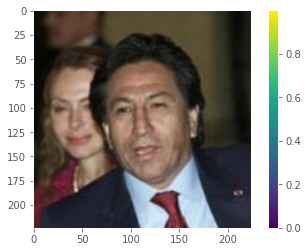

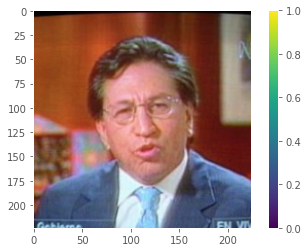

1
[0.9314636]
1


In [59]:
this_pair = 24
show_image(te_pairs[this_pair][0])
show_image(te_pairs[this_pair][1])
print(te_y[this_pair])
print(y_pred[this_pair])
print(1 if y_pred[this_pair]<2 else 0)